---
# ***GAN Generator for Geological Facies Modeling***
---

This project has the aim to build a Generative Adversarial Network (GAN) from scratch to generate synthetic geological facies models. This will include setting up the environment, preparing the data, building the model, training it and evaluating the results. This project is just and extension and variation of the work implemented by Suihong Song in his [paper](https://link.springer.com/article/10.1007/s10596-021-10059-w) "Geological Facies modeling based on progressive growing of generative adversarial networks (GANs)
Suihong Song (CUPB & Stanford), Tapan Mukerji (Stanford), and Jiagen Hou (CUPB)
CUPB: China University of Petroleum - Beijing". The github repository where I got the dataset and some of the guidlines for implementing my project can be found in this [link](https://github.com/SuihongSong/GeoModeling_Unconditional_ProGAN/tree/master/).


## **Introduction and Setting Up the Environment**

As explained before, the objective of this project is to generate a GAN for generating geological facies models. In general, we know that a GAN consists of two neural networks:


*   Generator (G): Which creates the synthetic data resembling the real one
*   Discriminator (D): Which distinguishes between the real data and the synthetic data geberated by the Generator

Since they are trained simultaneously, we have as a result a minmax game where the Generator tries to minimize the Discriminato's ability to detect fakes, and so on the Discriminator tries to maximize its accuracy. The idea here is to reach out to a point where the Discriminator is not able to recognize which model has been generated by the generator or if it is a real one.

Now, ProGANs (Progressive Growing of GANs) introduce a training methodology where the GAN starts training with low resulution images and progresively increases the resolution by adding layers to both the Generator and the Discriminator. This approach helps in stabilizing training and improving the quality of the generated images. We will be first exploring GANs and then move towards the use of ProGANS because of their complexity



First, let's install the necessary libraries. PyTorch and torchvision are essential for building and training the GAN. Also we are installing other main required libraries like numpy, matplotlib, seaborn, etc.

In [ ]:
# Install PyTorch and torchvision
!pip install torch torchvision

# Install other required libraries
!pip install numpy matplotlib seaborn tensorflow tqdm

Now, let's proceed to import all the required libraries for data processing, visualization, and building the GAN.

In [ ]:
import os
import time
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
from sklearn import manifold
from scipy.stats import kde
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Below, you will see the versions of the libraries used

In [ ]:
# let's get the version of the libraries that will be used
!python --version
print('NumPy', np.__version__)
print('Pandas', pd.__version__)
print('Seaborn', sns.__version__)
print("Matplotlib", plt.matplotlib.__version__)
print("TensorFlow", tf.__version__)
print("PyTorch  ", torch.__version__)

Python 3.11.11
NumPy 1.26.4
Pandas 2.2.2
Seaborn 0.13.2
Matplotlib 3.10.0
TensorFlow 2.17.1
PyTorch   2.5.1+cu121


## **Data Preprocessing**

The models that will be used in this project have been generated using Petrel and then have been exported in GSLIB format. The GSLIB files include header lines with metadata (like the number of realizations and property names) and data lines, where each line correspond to a pixel in a 64x64 grid.
These files were converted by the authors to TFR format. The conversion from this format to TFRecord involved the following steps:


**1.   Loading the Facies Model:** Reading the GSLIB file, parsing the facies code and arraging them into Numpy arrays

**2.   Data Augmentation:** Augment the dataset by flipping images to simulate additional geological scenarios.

**3.   Generating Probability Maps:** Apply Gaussian kernel smoothing to create probability maps representing the likelihood of each facies.

**4.   Generating Well Facies Data:** Simulate well data by randomly sampling facies at specific location based on the probability maps

**5. Preparing Labels (Global Features):** Extract global features (e.g., channel orientation, width) and normalize them.

**6.  Saving to TFRecord:** Use a TFRecordExporter class to write the data into TFRecord files for efficient storage and access during training..


In this project, we will convert the TFRecord format into NumPy array and then will create a PyTorch Dataset. For doing this let's create a function to parse the TFRecords and save them as using a Numpy array.
This function reads each TFRecord file, parsing the shape and data features. Then, each  image is reshaped based on its shape. If the image shape doesn't match the desired max_shape, it's resized using OpenCV. Finally, all processed images are stacked into a single NumPy array. The resulting array is saved as a .npy file for later use.

In [ ]:
# Function to parse TFRecords and save as NumPy arrays
def convert_tfrecords_to_numpy(tfrecord_filenames, output_file):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_filenames)
    data_list = []
    max_shape = [1, 64, 64]  # Adjust as necessary

    for raw_record in tqdm(raw_dataset, desc="Converting TFRecords"):
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        shape = example.features.feature['shape'].int64_list.value
        data = example.features.feature['data'].bytes_list.value[0]
        img = np.frombuffer(data, dtype=np.uint8).reshape(shape)

        # Resize or pad to max_shape
        if img.shape != max_shape:
            # Resize the image to (64, 64)
            img_resized = cv2.resize(img[0], (max_shape[2], max_shape[1]))
            img = img_resized[np.newaxis, ...]

        data_list.append(img)

    # Stack all images into a NumPy array
    data_array = np.stack(data_list, axis=0)
    np.save(output_file, data_array)
    print(f"Data saved to {output_file}")


Now, let's proceed to import the datafiles and convert this files into NumPy



In [ ]:
# Define the paths to the TFRecord files
tfrecord_filenames = [
    '/content/Training_data/TrainingData(MultiChannels_Version4)-1r02.tfrecords',
    '/content/Training_data/TrainingData(MultiChannels_Version4)-1r03.tfrecords',
    '/content/Training_data/TrainingData(MultiChannels_Version4)-1r04.tfrecords',
    '/content/Training_data/TrainingData(MultiChannels_Version4)-1r05.tfrecords',
    '/content/Training_data/TrainingData(MultiChannels_Version4)-1r06.tfrecords'
]

output_file = 'training_data.npy'

# Converting the tfrecord_filenames to numpy
convert_tfrecords_to_numpy(tfrecord_filenames, output_file)

# Path to the labels file
labels_path = '/content/Training_data/TrainingData(MultiChannels_Version4)-4rxx.labels'

labels = np.load(labels_path)
print('Labels shape:', labels.shape)

Converting TFRecords: 178200it [00:33, 5331.66it/s]


Data saved to training_data.npy
Labels shape: (35640, 4)


We are going now to create the PyTorch Dataset. Here the images are normalized to the range [-1, 1] which is the standard for GAN's. Also, getitem returns a tensor representation of the image

In [ ]:
class FaciesDataset(Dataset):
    def __init__(self, data_array):
        self.data = data_array.astype(np.float32)
        self.data = (self.data / 127.5) - 1.0  # Normalize to [-1, 1]
        print("Debug => After normalization, min:", self.data.min(), "max:", self.data.max())
        # Right after loading your dataset:
        print("Raw data min:", np.min(data_array), "max:", np.max(data_array))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        return torch.from_numpy(image)

Next, we initialize the dataset and the dataloader, here we will have a total of 178,200 samples. Also, the selected batch size will be equal to 16

In [ ]:
data_array = np.load('training_data.npy')
subset_size = 2000
indices = np.random.choice(data_array.shape[0], subset_size, replace=False)
data_array = data_array[indices]
print(f"Data shape: {data_array.shape}")  # Should be (num_samples, 1, 64, 64)

# Initialize combined_data with the original data
combined_data = data_array.copy()
print(f"Combined data shape (initial): {combined_data.shape}")

dataset = FaciesDataset(data_array)
batch_size = 16  # Adjust based on your GPU memory

# we also create a DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

Data shape: (2000, 1, 64, 64)
Combined data shape (initial): (2000, 1, 64, 64)
Debug => After normalization, min: -1.0 max: 1.0
Raw data min: 0 max: 255



## **Exploratory Data Analysis**

### **Image Grid**

Let's start exploring the basic properties of the dataset. First, let's visualize some samples of the data set and explore some of their characteristics

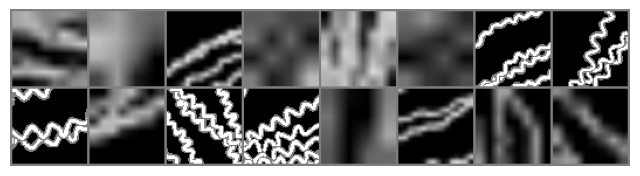

In [ ]:
import torchvision


def show_batch_of_images(images, nrow=8):
    """
    images: a torch Tensor of shape (B, C, H, W) in the range [-1,1].
    nrow  : how many images in one row of the grid
    """
    # 1) Make a grid *without* extra normalization:
    grid_img = torchvision.utils.make_grid(images, nrow=nrow, normalize=False)

    # 2) Shift/scale from [-1,1] to [0,1]:
    grid_img = grid_img * 0.5 + 0.5  # now in [0, 1]

    # 3) Convert to NumPy for plt.imshow (CHW -> HWC):
    np_img = grid_img.permute(1, 2, 0).cpu().numpy()

    # 4) Display:
    plt.figure(figsize=(8, 8))       # enlarge if needed
    plt.imshow(np_img, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.show()

# Usage:
dataiter = iter(dataloader)
images = next(dataiter)            # shape [batch_size, 1, 64, 64], in [-1,1]
show_batch_of_images(images[:64], nrow=8)

This grid provides a visual overview of the geological facies patterns in the dataset. The variations in texture and intensity indicate the diversity of the geological features captured.


### **PCA Analysis on Flattened Images**

Now, let's proceed to flatten the images to calculate the statistics and compute the mean pixel values and its standard deviation

In [ ]:
# Flatten the images to calculate statistics
flat_images = data_array.reshape(data_array.shape[0], -1)

# Calculate mean and standard deviation
mean_pixel_value = flat_images.mean()
std_pixel_value = flat_images.std()

print(f"Mean pixel value: {mean_pixel_value:.4f}")
print(f"Standard deviation of pixel values: {std_pixel_value:.4f}")


Mean pixel value: 77.6793
Standard deviation of pixel values: 77.6256


Once we have done this, let's proceed to see the histogram of the Pixel Values and see how the pixels are mostly concentrated.

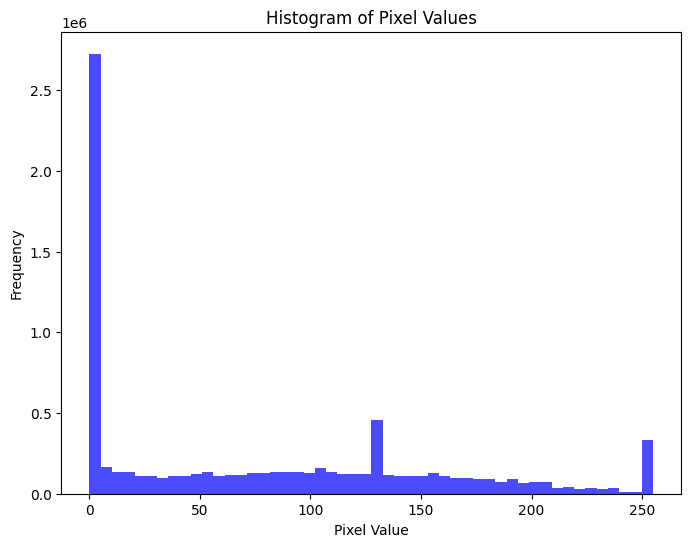

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(flat_images.flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Pixel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

The histogram reveals that most pixel values are concentrated around 0 and 255, suggesting that the dataset primarily contains binary-like data with some intermediate values.

In [ ]:
data_flattened = data_array.reshape(data_array.shape[0], -1)  # shape: (N, 64*64)
print("Data flattened shape:", data_flattened.shape)

Data flattened shape: (2000, 4096)


Now we fit PCA to understand the global dimensionality of the data.

Data flattened shape: (2000, 4096)


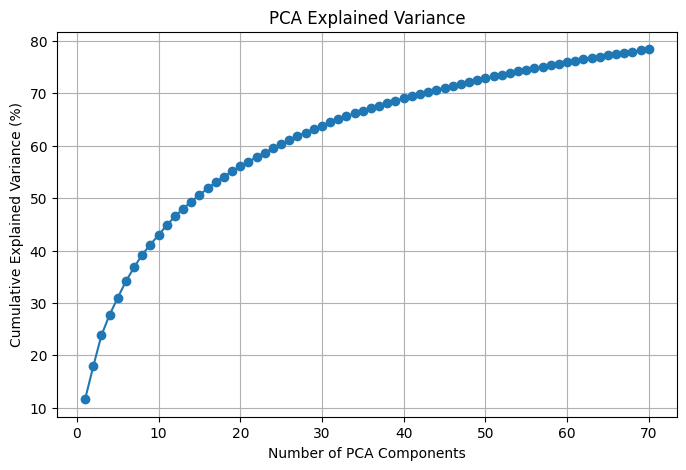

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
data_flattened = data_array.reshape(data_array.shape[0], -1)  # shape: (N, 64*64)
print("Data flattened shape:", data_flattened.shape)

# Fit PCA
n_components = 70  # or any number less than the number of features
pca = PCA(n_components=n_components, random_state=42)
pca.fit(data_flattened)

# Plot explained variance ratio (cumulative)
explained_variance = np.cumsum(pca.explained_variance_ratio_) * 100
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components + 1), explained_variance, marker='o', linestyle='-')
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()


## **Building and Training the GAN**

Having prepared a more balanced and diverse dataset, we now focus on building and training the GAN model. We will use a progressive growing approach. Instead of starting the GAN at full resolution (64x64), we begin at a lower resolution (e.g., 4x4). We train the model at this low resolution first, which allows it to learn coarse geological structures without being overwhelmed by fine details. After some training, we introduce new layers that double the resolution to 8x8, and we smoothly blend these new layers using a fade-in parameter alpha. This process repeats, going through resolutions like 16x16, 32x32, and finally 64x64. At each stage, we have a fade-in phase (where alpha goes from 0 to 1) and a stable phase (alpha=1.0). This methodology encourages stable training and better-quality results.
Likewise, instead of using all 178,200 images, we randomly choose 20,000 images. This speeds up each epoch because we iterate over fewer images, letting us reach more meaningful training iterations before times out.


In [ ]:
class FinalDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return torch.from_numpy(self.data[idx])

final_data = data_array

train_dataset = FaciesDataset(final_data)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)

Debug => After normalization, min: -1.0 max: 1.0
Raw data min: 0 max: 255


Here, it is implemented a Generator and a Discriminator that can grow progressively. The Generator starts with a small 4x4 layer and can add layers to double resolution step by step. The Discriminator works in reverse order. We train them using a WGAN-GP style loss. The Discriminator tries to push real sample scores up and fake sample scores down, while the Generator tries to make fake samples indistinguishable from real ones. The gradient penalty ensures the Discriminator does not become too sharp or saturate, stabilizing training. By carefully adjusting the learning rates, betas for Adam, and balancing the loss terms, we maintain a stable training environment.

First, we will implement some utilities for progressive growing

In [ ]:
# Utilities for progressive growing
def upscale2d(x, factor=2):
    # Nearest neighbor upscale
    return F.interpolate(x, scale_factor=factor, mode='nearest')

class GenBlock(nn.Module):
    # A block for the generator that doubles resolution
    # Simple: conv->relu->conv->relu
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch,out_ch,3,1,1)
        self.conv2 = nn.Conv2d(out_ch,out_ch,3,1,1)
        self.activation = nn.LeakyReLU(0.2)
    def forward(self,x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        return x

class ToRGB(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv = nn.Conv2d(ch, 1, 1, 1,0)
    def forward(self,x):
        return self.conv(x)

Now, we can proceed to implement the Generator class

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.latent_dim = latent_dim
        self.alpha = 1.0

        # Added one more channel stage for 64x64
        self.channels = [512,512,256,128,64]

        self.const = nn.Parameter(torch.randn(1,512,4,4))

        self.blocks = nn.ModuleList()
        self.torgb = nn.ModuleList()

        # Base ToRGB for 4x4
        self.torgb.append(ToRGB(self.channels[0]))

        # 4x4 -> 8x8
        self.blocks.append(GenBlock(self.channels[0], self.channels[1]))
        self.torgb.append(ToRGB(self.channels[1]))

        # 8x8 -> 16x16
        self.blocks.append(GenBlock(self.channels[1], self.channels[2]))
        self.torgb.append(ToRGB(self.channels[2]))

        # 16x16 -> 32x32
        self.blocks.append(GenBlock(self.channels[2], self.channels[3]))
        self.torgb.append(ToRGB(self.channels[3]))

        # 32x32 -> 64x64 (Newly added)
        self.blocks.append(GenBlock(self.channels[3], self.channels[4]))
        self.torgb.append(ToRGB(self.channels[4]))

    def forward(self, z, resolution_log2):
        # resolution_log2: 2->4x4, 3->8x8, 4->16x16, 5->32x32, 6->64x64
        index = resolution_log2 - 2

        batch = z.size(0)
        x = self.const.expand(batch, -1, -1, -1)

        for i in range(index):
            x = F.interpolate(x, scale_factor=2, mode='nearest')
            x = self.blocks[i](x)

        out_new = self.torgb[index](x)

        if index > 0 and self.alpha < 1.0:
            # Reconstruct previous stage output
            y = self.const.expand(batch, -1, -1, -1)
            for i_ in range(index-1):
                y = F.interpolate(y, scale_factor=2, mode='nearest')
                y = self.blocks[i_](y)
            out_prev = self.torgb[index-1](y)
            out_prev_up = F.interpolate(out_prev, scale_factor=2, mode='nearest')
            out = (1.0 - self.alpha) * out_prev_up + self.alpha * out_new
        else:
            out = out_new

        return out


This are the utility classes for the Discriminator

In [ ]:
class FromRGB(nn.Module):
    """
    Converts single-channel input to feature maps using a 1x1 convolution.
    """
    def __init__(self, ch):
        super().__init__()
        self.conv = nn.Conv2d(1, ch, 1, 1, 0)  # 1x1 convolution

    def forward(self, x):
        return self.conv(x)

class DiscBlock(nn.Module):
    """
    A block for the Discriminator that reduces resolution.
    Consists of two convolutional layers + LeakyReLU activations.
    """
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, in_ch, 3, 1, 1)
        self.conv2 = nn.Conv2d(in_ch, out_ch, 3, 1, 1)
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        return x

Now we continue the Discriminator

In [ ]:

class Discriminator(nn.Module):
    """
    Discriminator for Progressive Growing of GANs (ProGAN) with a stable, uniform
    channel configuration.

    Resolutions: 4x4, 8x8, 16x16, 32x32, 64x64
    All have 512 channels.
    """
    def __init__(self):
        super().__init__()
        self.alpha = 1.0

        # Use 512 channels at all resolutions
        self.channels = [512, 512, 512, 512, 512]

        # fromRGB layers: all produce 512 channels
        self.fromrgb = nn.ModuleList([
            FromRGB(512), # 4x4
            FromRGB(512), # 8x8
            FromRGB(512), # 16x16
            FromRGB(512), # 32x32
            FromRGB(512)  # 64x64
        ])

        # Blocks for downsampling, always 512 -> 512
        self.blocks = nn.ModuleList([
            DiscBlock(512, 512),  # 8x8->4x4
            DiscBlock(512, 512),  # 16x16->8x8
            DiscBlock(512, 512),  # 32x32->16x16
            DiscBlock(512, 512)   # 64x64->32x32
        ])

        # Merge convolutions for fade-in: all 512->512 where used
        self.merge_conv = nn.ModuleList([
            nn.Identity(),              # index=0: 4x4
            nn.Identity(),              # index=1: 8x8
            nn.Conv2d(512, 512, 1, 1),  # index=2: 16x16 merging
            nn.Conv2d(512, 512, 1, 1),  # index=3: 32x32 merging
            nn.Conv2d(512, 512, 1, 1)   # index=4: 64x64 merging
        ])

        # Final conv layers: all 512->512
        self.final_conv = nn.ModuleList([
            nn.Conv2d(512, 512, 3, 1, 1), # 4x4
            nn.Conv2d(512, 512, 3, 1, 1), # 8x8
            nn.Conv2d(512, 512, 3, 1, 1), # 16x16
            nn.Conv2d(512, 512, 3, 1, 1), # 32x32
            nn.Conv2d(512, 512, 3, 1, 1)  # 64x64
        ])

        # Final fully connected layers: always 512 * 4 * 4 input
        self.final_fc = nn.ModuleList([
            nn.Linear(512 * 4 * 4, 1), # 4x4
            nn.Linear(512 * 4 * 4, 1), # 8x8
            nn.Linear(512 * 4 * 4, 1), # 16x16
            nn.Linear(512 * 4 * 4, 1), # 32x32
            nn.Linear(512 * 4 * 4, 1)  # 64x64
        ])

    def forward(self, x, resolution_log2):
        # resolution_log2: 2->4x4, 3->8x8, 4->16x16, 5->32x32, 6->64x64
        index = resolution_log2 - 2

        if index > 0 and self.alpha < 1.0:
            # High-resolution path at current scale
            high = self.fromrgb[index](x)

            # Downsample input to previous resolution
            x_down = F.avg_pool2d(x, 2)
            low = self.fromrgb[index - 1](x_down)

            # Upscale low-resolution feature maps to match high-resolution dimension
            low_up = F.interpolate(low, scale_factor=2, mode='nearest')
            low_up = self.merge_conv[index](low_up)

            # Blend the two paths
            out = (1.0 - self.alpha) * low_up + self.alpha * high
        else:
            # No fade-in or base resolution
            out = self.fromrgb[index](x)

        # Process through blocks
        for i in range(index, 0, -1):
            out = self.blocks[i - 1](out)
            out = F.avg_pool2d(out, 2)

        # Final conv + FC
        out = F.leaky_relu(self.final_conv[index](out), 0.2)
        out = out.view(out.size(0), -1)
        out = self.final_fc[index](out)
        return out

With the models and utility functions defined, we proceed with the training loop. We specify a series of resolutions and train through them. For each resolution, we do a fade-in phase (alpha from 0 to 1) and a stable phase (alpha=1). Each batch involves:

1. Sampling latent vectors z.
2. Generating fake images.
3. Computing Discriminator loss (WGAN-GP): real_out should be high, fake_out low, plus the gradient penalty.
4. Updating the Discriminator.
5. Updating the Generator to produce more realistic images.

This iterative process is repeated for each resolution until we reach the final target resolution.

In [ ]:
def sample_latent(batch_size, latent_dim=128, device='cuda'):
    """
    Samples latent vectors from a standard normal distribution.

    Args:
        batch_size (int): Number of samples to generate.
        latent_dim (int): Dimensionality of the latent space.
        device (torch.device): Device to place the tensor.

    Returns:
        torch.Tensor: Sampled latent vectors.
    """
    return torch.randn(batch_size, latent_dim, device=device)

def gradient_penalty(D, real, fake, resolution_log2, device='cuda'):
    """
    Computes the gradient penalty for WGAN-GP.

    Args:
        D (nn.Module): Discriminator model.
        real (torch.Tensor): Real images.
        fake (torch.Tensor): Fake images generated by the Generator.
        resolution_log2 (int): Log2 of the current resolution.
        device (torch.device): Device to perform computations.

    Returns:
        torch.Tensor: Gradient penalty.
    """
    alpha = torch.rand(real.size(0), 1, 1, 1, device=device)
    interp = (alpha * real + (1 - alpha) * fake).requires_grad_(True)
    d_interp = D(interp, resolution_log2)
    grad = torch.autograd.grad(
        outputs=d_interp, inputs=interp,
        grad_outputs=torch.ones_like(d_interp),
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    grad = grad.view(grad.size(0), -1)
    norm = grad.norm(2, dim=1)
    gp = ((norm - 1) ** 2).mean()
    return gp

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize Generator and Discriminator
G = Generator(latent_dim=128).to(device)
D = Discriminator().to(device)

def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight, a=0.2)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

G.apply(init_weights)
D.apply(init_weights)

# Define optimizers with learning rate and betas as per WGAN-GP recommendations
lr = 1e-6  # or possibly 5e-6 if still too large
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.0, 0.9))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.0, 0.9))

Using device: cuda


We proceed to implement the training parameters

In [ ]:
# Progressive Training Parameters
resolutions = [4, 8, 16, 32, 64]  # Resolutions to train on

# Define training parameters in terms of kimg (kilo-images)
# fade_in_kimg = 10 means 10,000 images processed during fade-in at the current resolution
# stable_kimg = 10 means 10,000 images processed during the stable phase.
fade_in_kimg = 900
stable_kimg = 900

latent_dim = 128      # Dimensionality of the latent space

# Initialize Mixed Precision Scalers
scaler_G = GradScaler()
scaler_D = GradScaler()

<ipython-input-46-598840fe5ba5>:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_G = GradScaler()
<ipython-input-46-598840fe5ba5>:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_D = GradScaler()


Now, we proceed with the Training Loop


===> Setting learning rates for resolution 4x4: G_lr=5e-06, D_lr=5e-06
Resolution: 4x4, Fade-in Phase


Fade-In Phase:   0%|          | 0/56250 [00:00<?, ?it/s]<ipython-input-52-2513d4a7ec2f>:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Fade-In Phase:   0%|          | 0/56250 [00:09<?, ?it/s]
<ipython-input-52-2513d4a7ec2f>:81: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Fade-In Phase: 100%|██████████| 56250/56250 [09:52<00:00, 94.94it/s] 


[Fade-in finished @ resolution=4]
  * alpha=1.00
  * avg D loss=-2.7582
  * avg G loss=0.1001
Saved fade-in checkpoint: ./checkpoints/fadein_res4.pth
Resolution: 4x4, Stable Phase


Stable Phase:   0%|          | 0/56250 [00:00<?, ?it/s]<ipython-input-52-2513d4a7ec2f>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-52-2513d4a7ec2f>:166: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Stable Phase: 100%|██████████| 56250/56250 [09:49<00:00, 95.37it/s] 


[Stable finished @ resolution=4]
  * alpha=1.00
  * avg D loss=-2.7638
  * avg G loss=-0.0299


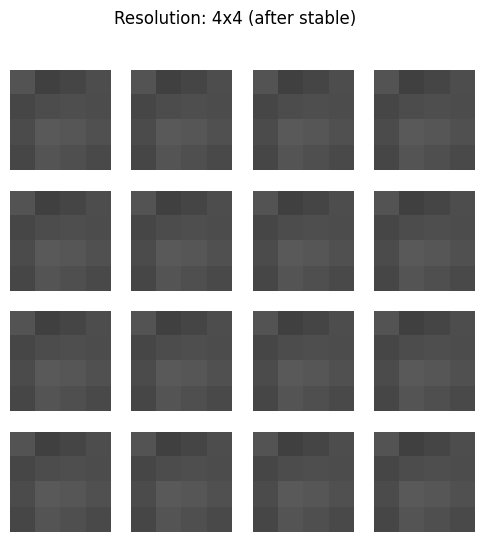

Saved stable checkpoint: ./checkpoints/stable_res4.pth

===> Setting learning rates for resolution 8x8: G_lr=5e-06, D_lr=5e-06
Resolution: 8x8, Fade-in Phase


Fade-In Phase: 100%|██████████| 56250/56250 [18:50<00:00, 49.74it/s]


[Fade-in finished @ resolution=8]
  * alpha=1.00
  * avg D loss=-1.6631
  * avg G loss=4.9725
Saved fade-in checkpoint: ./checkpoints/fadein_res8.pth
Resolution: 8x8, Stable Phase


Stable Phase: 100%|██████████| 56250/56250 [15:41<00:00, 59.73it/s]


[Stable finished @ resolution=8]
  * alpha=1.00
  * avg D loss=-0.9281
  * avg G loss=22.4728


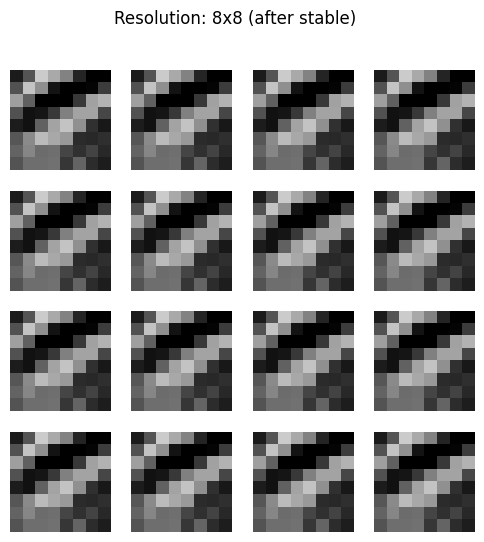

Saved stable checkpoint: ./checkpoints/stable_res8.pth

===> Setting learning rates for resolution 16x16: G_lr=1e-06, D_lr=1e-06
Resolution: 16x16, Fade-in Phase


Fade-In Phase: 100%|██████████| 56250/56250 [41:52<00:00, 22.39it/s]


[Fade-in finished @ resolution=16]
  * alpha=1.00
  * avg D loss=-6.0335
  * avg G loss=12.3870
Saved fade-in checkpoint: ./checkpoints/fadein_res16.pth
Resolution: 16x16, Stable Phase


Stable Phase: 100%|██████████| 56250/56250 [36:25<00:00, 25.74it/s]


[Stable finished @ resolution=16]
  * alpha=1.00
  * avg D loss=-4.4356
  * avg G loss=10.8345


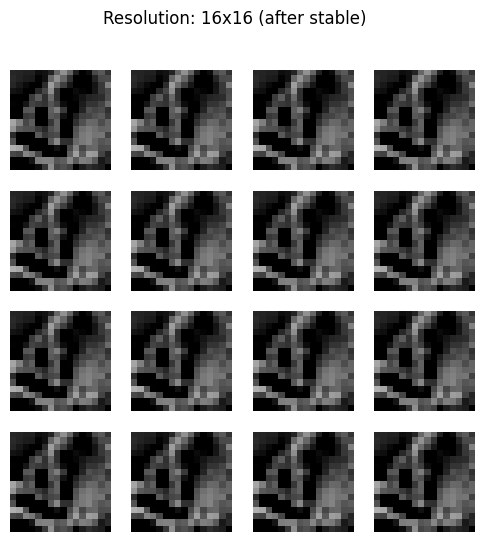

Saved stable checkpoint: ./checkpoints/stable_res16.pth

===> Setting learning rates for resolution 32x32: G_lr=1e-07, D_lr=1e-07
Resolution: 32x32, Fade-in Phase


Fade-In Phase: 100%|██████████| 56250/56250 [1:58:08<00:00,  7.94it/s]


[Fade-in finished @ resolution=32]
  * alpha=1.00
  * avg D loss=-7.6272
  * avg G loss=-4.5986
Saved fade-in checkpoint: ./checkpoints/fadein_res32.pth
Resolution: 32x32, Stable Phase


Stable Phase: 100%|██████████| 56250/56250 [1:42:23<00:00,  9.16it/s]


[Stable finished @ resolution=32]
  * alpha=1.00
  * avg D loss=-12.9058
  * avg G loss=4.5886


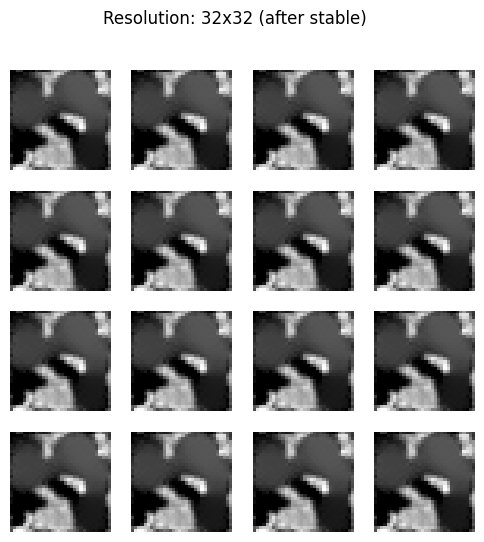

Saved stable checkpoint: ./checkpoints/stable_res32.pth

===> Setting learning rates for resolution 64x64: G_lr=5e-08, D_lr=5e-08
Resolution: 64x64, Fade-in Phase


Fade-In Phase: 100%|██████████| 56250/56250 [7:12:31<00:00,  2.17it/s]


[Fade-in finished @ resolution=64]
  * alpha=1.00
  * avg D loss=-22.8268
  * avg G loss=11.7086
Saved fade-in checkpoint: ./checkpoints/fadein_res64.pth
Resolution: 64x64, Stable Phase


Stable Phase: 100%|██████████| 56250/56250 [6:14:18<00:00,  2.50it/s]


[Stable finished @ resolution=64]
  * alpha=1.00
  * avg D loss=-36.4417
  * avg G loss=17.0727


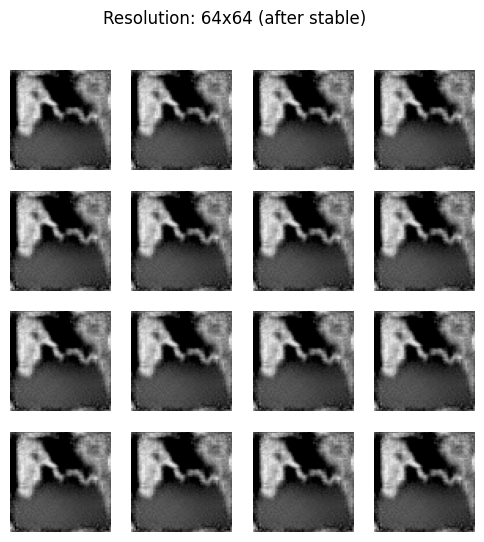

Saved stable checkpoint: ./checkpoints/stable_res64.pth
Training complete!


In [ ]:
# Example: Per-resolution learning rates
resolution_lr_map = {
    4:  (5e-6, 5e-6),    # (G_lr, D_lr) for 4x4
    8:  (1e-6, 1e-6),    # for 8x8
    16: (1e-6, 1e-6),    # for 16x16
    32: (1e-7, 1e-7),    # for 32x32
    64: (5e-8, 5e-8),    # for 64x64
}

# --- your existing loop ---
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

for phase, res in enumerate(resolutions):
    resolution_log2 = int(np.log2(res))

    # ------------------------------------------------------------------------
    # NEW: Adjust per-resolution learning rates by modifying Adam param_groups
    # ------------------------------------------------------------------------
    G_lr, D_lr = resolution_lr_map.get(res, (1e-5, 1e-5))  # fallback if missing
    print(f"\n===> Setting learning rates for resolution {res}x{res}: G_lr={G_lr}, D_lr={D_lr}")
    for param_group in optimizer_G.param_groups:
        param_group["lr"] = G_lr
    for param_group in optimizer_D.param_groups:
        param_group["lr"] = D_lr

    # -------------------------
    # Fade-in Phase
    # -------------------------
    G.alpha = 0.0
    D.alpha = 0.0
    fade_in_iterations = int((fade_in_kimg * 1000) // batch_size)
    images_processed = 0

    print(f"Resolution: {res}x{res}, Fade-in Phase")
    pbar = tqdm(total=fade_in_iterations, desc=f"Fade-In Phase")

    total_d_loss_fade = 0.0
    total_g_loss_fade = 0.0

    for iteration in range(fade_in_iterations):
        alpha_value = (iteration + 1) / fade_in_iterations
        G.alpha = alpha_value
        D.alpha = alpha_value

        try:
            real_images = next(dataiter)
        except:
            dataiter = iter(dataloader)
            real_images = next(dataiter)

        real_images = real_images.to(device)
        factor = 64 // res
        if factor > 1:
            real_images = F.avg_pool2d(real_images, factor)

        # --- Train D ---
        optimizer_D.zero_grad()
        with autocast():
            z = sample_latent(real_images.size(0), latent_dim, device=device)
            fake_images = G(z, resolution_log2)
            real_out = D(real_images, resolution_log2)
            fake_out = D(fake_images.detach(), resolution_log2)

            d_loss_real = -real_out.mean()
            d_loss_fake = fake_out.mean()

            # e.g. 0.1 * gradient penalty (you can raise it if you want)
            gp = gradient_penalty(D, real_images, fake_images, resolution_log2, device=device)
            d_loss = d_loss_real + d_loss_fake + 0.5 * gp

        # backward + grad clipping on D
        scaler_D.scale(d_loss).backward()
        scaler_D.unscale_(optimizer_D)
        torch.nn.utils.clip_grad_norm_(D.parameters(), 1.0)
        scaler_D.step(optimizer_D)
        scaler_D.update()

        # --- Train G ---
        optimizer_G.zero_grad()
        with autocast():
            z = sample_latent(real_images.size(0), latent_dim, device=device)
            fake_images = G(z, resolution_log2)
            fake_out = D(fake_images, resolution_log2)
            g_loss = -fake_out.mean()

        scaler_G.scale(g_loss).backward()
        scaler_G.unscale_(optimizer_G)
        torch.nn.utils.clip_grad_norm_(G.parameters(), 1.0)
        scaler_G.step(optimizer_G)
        scaler_G.update()

        total_d_loss_fade += d_loss.item()
        total_g_loss_fade += g_loss.item()

        images_processed += real_images.size(0)
        pbar.update(1)

    pbar.close()
    avg_d_loss_fade = total_d_loss_fade / fade_in_iterations
    avg_g_loss_fade = total_g_loss_fade / fade_in_iterations

    print(f"[Fade-in finished @ resolution={res}]")
    print(f"  * alpha={G.alpha:.2f}")
    print(f"  * avg D loss={avg_d_loss_fade:.4f}")
    print(f"  * avg G loss={avg_g_loss_fade:.4f}")

    # Save checkpoint after fade-in phase
    checkpoint_path = os.path.join(checkpoint_dir, f"fadein_res{res}.pth")
    torch.save({
        'G_state_dict': G.state_dict(),
        'D_state_dict': D.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
        'alpha': G.alpha,
    }, checkpoint_path)
    print(f"Saved fade-in checkpoint: {checkpoint_path}")

    # -------------------------
    # Stable Phase
    # -------------------------
    G.alpha = 1.0
    D.alpha = 1.0
    stable_iterations = int((stable_kimg * 1000) // batch_size)
    print(f"Resolution: {res}x{res}, Stable Phase")

    pbar = tqdm(total=stable_iterations, desc=f"Stable Phase")

    total_d_loss_stable = 0.0
    total_g_loss_stable = 0.0

    for iteration in range(stable_iterations):
        try:
            real_images = next(dataiter)
        except:
            dataiter = iter(dataloader)
            real_images = next(dataiter)

        real_images = real_images.to(device)
        factor = 64 // res
        if factor > 1:
            real_images = F.avg_pool2d(real_images, factor)

        # --- Train D ---
        optimizer_D.zero_grad()
        with autocast():
            z = sample_latent(real_images.size(0), latent_dim, device=device)
            fake_images = G(z, resolution_log2)
            real_out = D(real_images, resolution_log2)
            fake_out = D(fake_images.detach(), resolution_log2)

            d_loss_real = -real_out.mean()
            d_loss_fake = fake_out.mean()

            gp = gradient_penalty(D, real_images, fake_images, resolution_log2, device=device)
            d_loss = d_loss_real + d_loss_fake + 0.5 * gp

        scaler_D.scale(d_loss).backward()
        scaler_D.unscale_(optimizer_D)
        torch.nn.utils.clip_grad_norm_(D.parameters(), 1.0)
        scaler_D.step(optimizer_D)
        scaler_D.update()

        # --- Train G ---
        optimizer_G.zero_grad()
        with autocast():
            z = sample_latent(real_images.size(0), latent_dim, device=device)
            fake_images = G(z, resolution_log2)
            fake_out = D(fake_images, resolution_log2)
            g_loss = -fake_out.mean()

        scaler_G.scale(g_loss).backward()
        scaler_G.unscale_(optimizer_G)
        torch.nn.utils.clip_grad_norm_(G.parameters(), 1.0)
        scaler_G.step(optimizer_G)
        scaler_G.update()

        total_d_loss_stable += d_loss.item()
        total_g_loss_stable += g_loss.item()
        pbar.update(1)

    pbar.close()
    avg_d_loss_stable = total_d_loss_stable / stable_iterations
    avg_g_loss_stable = total_g_loss_stable / stable_iterations

    print(f"[Stable finished @ resolution={res}]")
    print(f"  * alpha={G.alpha:.2f}")
    print(f"  * avg D loss={avg_d_loss_stable:.4f}")
    print(f"  * avg G loss={avg_g_loss_stable:.4f}")

    # Quick preview images
    with torch.no_grad():
        z_preview = torch.randn(16, latent_dim, device=device)
        fakes_preview = G(z_preview, resolution_log2=resolution_log2).cpu().numpy()
        fakes_disp = (fakes_preview * 0.5) + 0.5

    fig, axs = plt.subplots(4, 4, figsize=(6,6))
    for i, ax in enumerate(axs.flat):
        ax.imshow(fakes_disp[i, 0], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
    fig.suptitle(f"Resolution: {res}x{res} (after stable)")
    plt.show()

    # Save checkpoint
    checkpoint_path = os.path.join(checkpoint_dir, f"stable_res{res}.pth")
    torch.save({
        'G_state_dict': G.state_dict(),
        'D_state_dict': D.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
        'alpha': G.alpha,
    }, checkpoint_path)
    print(f"Saved stable checkpoint: {checkpoint_path}")

print("Training complete!")


After training, we can use the saved generator model to produce synthetic geological facies models and visually inspect them. This serves as a quick quality check of the model's performance. Additional quantitative evaluations (like spatial continuity metrics or multi-scale sliced Wasserstein distance) can be implemented as desired.

In [ ]:
# Save models
torch.save(G.state_dict(), "generator_model.pth")
torch.save(D.state_dict(), "discriminator_model.pth")


## **Evaluating the Generated Model**

For this section, we proceed to evaluate the quality and diversity of the geological facies models generated by the GAN. The evaluation is conducted through both qualitative and quantitative assessments to ensure that the generated facies resemble realistic geological patterns and capture the variability of the training data.


In [ ]:
# We load the trained generator model weights (in case you restarted the kernel after training)
G_loaded = Generator(latent_dim=128).to(device)
G_loaded.load_state_dict(torch.load("generator_model.pth", map_location=device))
G_loaded.eval()

<ipython-input-54-937dcbf64ad1>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G_loaded.load_state_dict(torch.load("generator_model.pth", map_location=device))


Generator(
  (blocks): ModuleList(
    (0): GenBlock(
      (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (1): GenBlock(
      (conv1): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (2): GenBlock(
      (conv1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (3): GenBlock(
      (conv1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
    )
  )


  We begin by generating a batch of synthetic facies models and directly comparing them to real samples from the dataset. This allows us to assess whether the GAN successfully replicates realistic facies boundaries, spatial patterns, and overall geological structures. By visualizing multiple samples, we can identify any obvious artifacts or anomalies that may indicate issues like mode collapse or insufficient training.

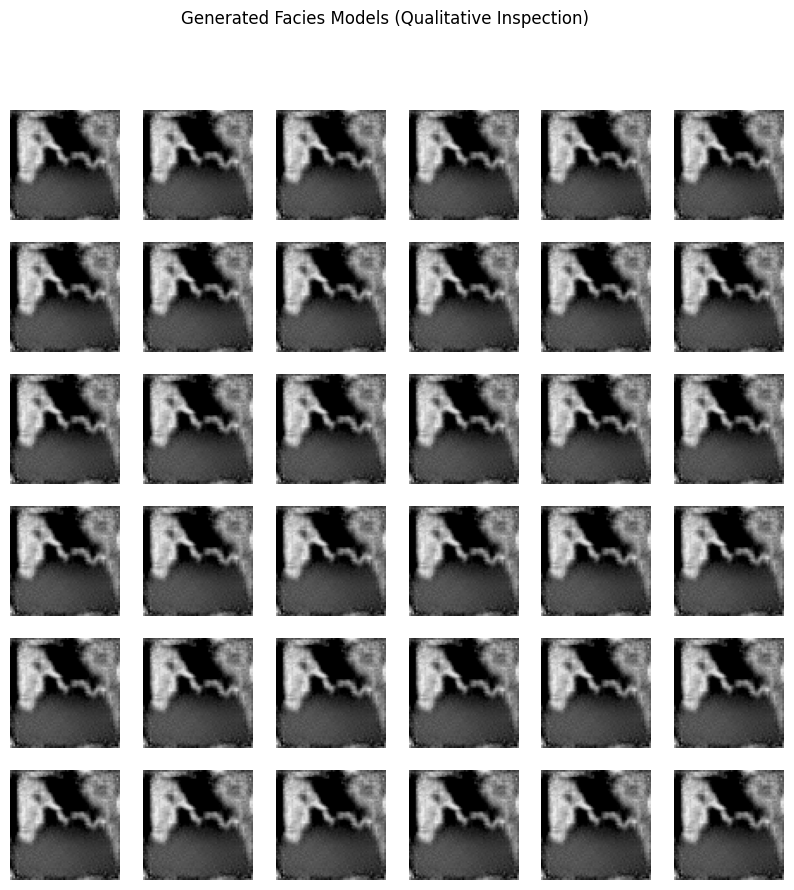

In [ ]:
# Generate a batch of synthetic facies models for inspection
with torch.no_grad():
    z = torch.randn(36, 128, device=device)
    # Assume final resolution is 64x64 -> resolution_log2 = 6
    fake_samples = G_loaded(z, resolution_log2=6).cpu().numpy()

fake_samples_disp = (fake_samples * 0.5) + 0.5  # Convert from [-1,1] to [0,1]

fig, axs = plt.subplots(6, 6, figsize=(10,10))
for i, ax in enumerate(axs.flat):
    ax.imshow(fake_samples_disp[i,0], cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
plt.suptitle("Generated Facies Models (Qualitative Inspection)")
plt.show()


  To quantitatively measure the similarity between the generated and real facies distributions, we employ the **Multi-Scale Sliced Wasserstein Distance (MS-SWD)**. MS-SWD evaluates the distance between the statistical distributions of real and synthetic images across multiple spatial scales, providing a comprehensive metric of distributional alignment. Lower MS-SWD values signify a closer match between the generated data and the real data distribution, indicating effective training.

In [ ]:
def pixel_norm_desc(desc):
    desc = desc - np.mean(desc, axis=(0,2,3), keepdims=True)
    desc = desc / (np.std(desc, axis=(0,2,3), keepdims=True) + 1e-8)
    desc = desc.reshape(desc.shape[0], -1)
    return desc

def get_descriptors(minibatch, nhood_size=5, nhoods_per_image=32):
    # minibatch: [N,3,H,W] assumed 3-channel
    # If single-channel, we repeat it 3 times to form RGB-like
    S = minibatch.shape
    assert S[1] == 3
    N = nhoods_per_image * S[0]
    H = nhood_size // 2
    nhood, chan, x, y = np.ogrid[0:N, 0:3, -H:H+1, -H:H+1]
    img = nhood // nhoods_per_image
    x = x + np.random.randint(H, S[3]-H, size=(N,1,1,1))
    y = y + np.random.randint(H, S[2]-H, size=(N,1,1,1))
    idx = ((img * S[1] + chan)*S[2] + y)*S[3] + x
    desc = minibatch.flatten()[idx]
    return desc

def sliced_wasserstein(A, B, dir_repeats=4, dirs_per_repeat=64):
    # A, B: descriptors [N, D]
    results = []
    for _ in range(dir_repeats):
        dirs = np.random.randn(A.shape[1], dirs_per_repeat)
        dirs /= np.sqrt(np.sum(dirs**2, axis=0, keepdims=True))
        projA = np.matmul(A, dirs)
        projB = np.matmul(B, dirs)
        projA = np.sort(projA, axis=0)
        projB = np.sort(projB, axis=0)
        dists = np.abs(projA - projB)
        results.append(np.mean(dists))
    return np.mean(results)

# Prepare real and fake samples for MS-SWD evaluation
# Let's load a subset of real images from the original training dataset (data_array)
# If you do not have it, ensure that "data_array" from earlier steps is still in memory:
data_array = final_data
if 'data_array' not in globals():
    data_array = np.load('training_data.npy')  # original training data
# We will use 256 images for evaluation
num_eval = 256
indices = np.random.choice(data_array.shape[0], num_eval, replace=False)
real_subset = data_array[indices]  # shape (N,1,64,64)
real_subset = (real_subset / 127.5) -1.0
real_subset_3c = np.repeat(real_subset, 3, axis=1)  # Convert 1-channel to 3-channel

# Generate fake images for MS-SWD evaluation
with torch.no_grad():
    z = torch.randn(num_eval, 128, device=device)
    fakes = G_loaded(z, resolution_log2=6).cpu().numpy()
fakes_3c = np.repeat(fakes, 3, axis=1)
fakes_3c_uint8 = np.clip((fakes_3c*127.5+127.5),0,255).astype(np.uint8)
reals_3c_uint8 = np.clip((real_subset_3c*127.5+127.5),0,255).astype(np.uint8)

# Extract descriptors
desc_real_list = []
desc_fake_list = []
num_levels = 1  # We only consider single-level SWD for simplicity, or you can do multi-level by downscaling

# Extract descriptors from real and fake
desc_real = get_descriptors(reals_3c_uint8)
desc_real = desc_real.reshape(-1,3,5,5)  # nhood_size=5
desc_real = pixel_norm_desc(desc_real)

desc_fake = get_descriptors(fakes_3c_uint8)
desc_fake = desc_fake.reshape(-1,3,5,5)
desc_fake = pixel_norm_desc(desc_fake)

ms_swd_value = sliced_wasserstein(desc_real, desc_fake)
print("MS-SWD value (x1e3):", ms_swd_value*1e3)

MS-SWD value (x1e3): 176.9697076348915


  Assessing the geological realism of the generated models requires analyzing their spatial continuity and structural integrity. We utilize **variograms** to compare the spatial patterns of facies in the generated models against those in the real dataset. Variograms measure the degree of spatial correlation as a function of distance, allowing us to verify whether the GAN has accurately captured the spatial dependencies and geological anisotropies present in the real data.

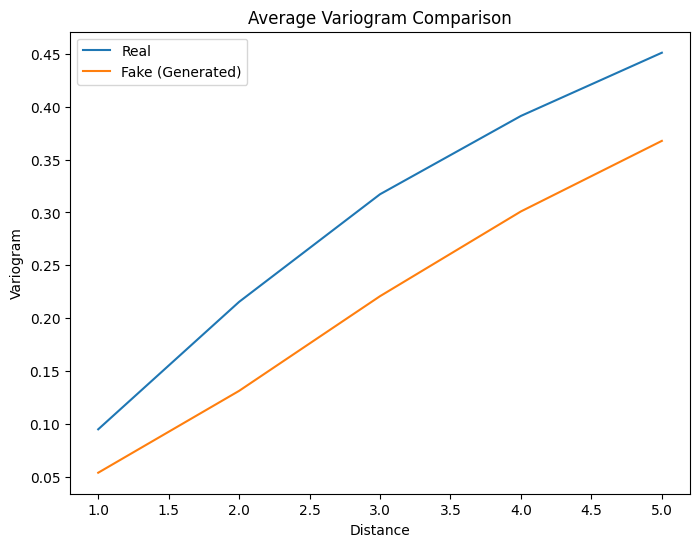

In [ ]:
# We already defined a "calculate_variogram" function above. We can reuse it here.
# Let's compute variograms for both real and generated samples and compare.

max_distance = 5

# Take a small sample of real images and compute variogram of their average
real_for_variogram = real_subset[:10,0]  # shape (10,64,64)
fake_for_variogram = fakes[:10,0]        # shape (10,64,64)

def average_variogram(imgs, max_distance):
    all_variograms = []
    for img in imgs:
        vario = calculate_variogram(img, max_distance)
        all_variograms.append(vario)
    return np.mean(all_variograms, axis=0)

real_vario = average_variogram(real_for_variogram, max_distance)
fake_vario = average_variogram(fake_for_variogram, max_distance)

plt.figure(figsize=(8,6))
plt.plot(range(1,max_distance+1), real_vario, label='Real')
plt.plot(range(1,max_distance+1), fake_vario, label='Fake (Generated)')
plt.xlabel('Distance')
plt.ylabel('Variogram')
plt.title('Average Variogram Comparison')
plt.legend()
plt.show()

  Beyond similarity, it's crucial to ensure that the GAN-generated models exhibit sufficient diversity, reflecting the variability inherent in geological formations. We analyze descriptor-based distances between groups of real and generated facies using the **Sliced Wasserstein Distance (SWD)** and visualize these relationships through **Multi-Dimensional Scaling (MDS)** plots. This analysis helps in confirming that the GAN does not suffer from mode collapse and that it generates a wide range of realistic facies variations.

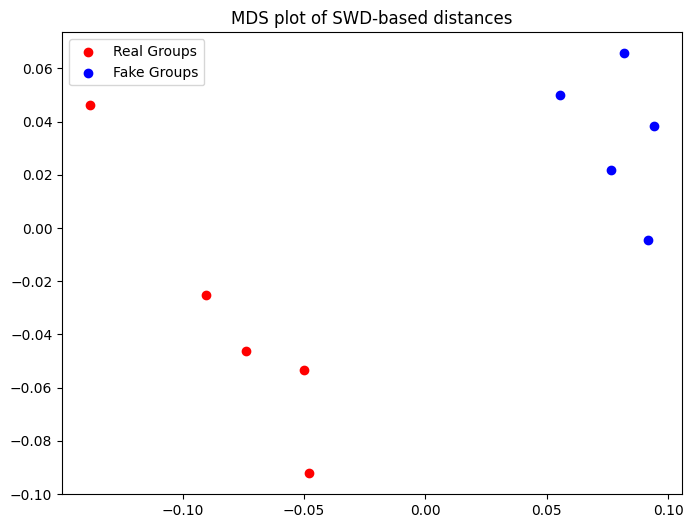

In [ ]:
def group_descriptors(images, groups=10, group_size=20):
    # images: (N,1,64,64) pre-normalized in [-1,1]
    # pick "groups * group_size" images
    selected = images[:groups*group_size]
    selected_3c = np.repeat(selected, 3, axis=1)
    # Compute descriptors for each group
    group_descs = []
    idxs = np.arange(groups*group_size)
    for g in range(groups):
        batch = selected_3c[g*group_size:(g+1)*group_size]
        batch_uint8 = np.clip((batch*127.5+127.5),0,255).astype(np.uint8)
        desc = get_descriptors(batch_uint8)
        desc = desc.reshape(-1,3,5,5)
        desc = pixel_norm_desc(desc)
        group_descs.append(desc)
    return group_descs

real_groups = group_descriptors(real_subset, groups=5, group_size=20)
fake_groups = group_descriptors(fakes, groups=5, group_size=20)

all_groups = real_groups + fake_groups
G = len(all_groups)
dist_matrix = np.zeros((G,G))
for i in range(G):
    for j in range(i+1,G):
        dist = sliced_wasserstein(all_groups[i], all_groups[j])
        dist_matrix[i,j] = dist
        dist_matrix[j,i] = dist

# MDS embedding
mds = manifold.MDS(n_components=2, max_iter=300, eps=1e-9, dissimilarity="precomputed")
coos = mds.fit_transform(dist_matrix)

plt.figure(figsize=(8,6))
plt.scatter(coos[:5,0], coos[:5,1], c='r', label='Real Groups')
plt.scatter(coos[5:,0], coos[5:,1], c='b', label='Fake Groups')
plt.title("MDS plot of SWD-based distances")
plt.legend()
plt.show()


In [ ]:
# ===========================
# 3. Basic sanity check
# ===========================
with torch.no_grad():
    z_test = torch.randn(4, 128, device=device)
    fake_test = G_loaded(z_test, resolution_log2=6)  # 64x64
print("Fake test shape:", fake_test.shape)  # (4, 1, 64, 64)
print("Min/Max/Mean:", fake_test.min().item(), fake_test.max().item(), fake_test.mean().item())
print("Any NaN?", torch.isnan(fake_test).any().item())

# If everything is good, you should see different min and max (not the same),
# and "Any NaN?" should be False.

Fake test shape: torch.Size([4, 1, 64, 64])
Min/Max/Mean: -1.9122862815856934 0.8835147619247437 -0.40569770336151123
Any NaN? False
